# Clasificación de Aeronaves con PyTorch y timm

Este notebook implementa un sistema de clasificación de aeronaves utilizando PyTorch y la librería timm para modelos preentrenados. El dataset contiene 100 clases de aeronaves diferentes.

## Estructura del Notebook:
1. **Configuración de GPU**: Detección automática de dispositivos (Mac M4 MPS / CUDA A100)
2. **Dataset y Transformaciones**: Carga y preparación de datos con división 80/10/10
3. **ResNet-18 Baseline**: Modelo congelado excepto clasificador final
4. **ResNet-18 Fine-tuning**: Descongelando capas 'layer4' y 'fc' para mejor rendimiento

Cada experimento incluye seguimiento completo de métricas y visualizaciones comparativas.

## 1. Configuración de GPU y Librerías

Configuramos el entorno de trabajo y detectamos automáticamente el mejor dispositivo disponible.

In [1]:
# Importaciones principales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

# Librerías para análisis y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from tqdm.auto import tqdm
import time
import os

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Librerías importadas exitosamente")

/Users/javier/Documents/202508_DeepL_lab1_B/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías importadas exitosamente


In [2]:
# Configuración de dispositivo GPU
def configurar_dispositivo():
    """
    Detecta y configura automáticamente el mejor dispositivo disponible.
    Prioridad: CUDA > MPS (Apple Silicon) > CPU
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        gpu_name = torch.cuda.get_device_name(0)
        memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🚀 Usando CUDA: {gpu_name}")
        print(f"💾 Memoria GPU: {memory_gb:.1f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("🍎 Usando Apple Silicon MPS")
        print("💾 Memoria compartida con sistema")
    else:
        device = torch.device('cpu')
        print("💻 Usando CPU (advertencia: entrenamiento será lento)")
    
    # Configuraciones adicionales para rendimiento
    torch.backends.cudnn.benchmark = True if device.type == 'cuda' else False
    
    return device

# Configurar dispositivo
device = configurar_dispositivo()
print(f"\n✅ Dispositivo configurado: {device}")

🍎 Usando Apple Silicon MPS
💾 Memoria compartida con sistema

✅ Dispositivo configurado: mps


In [3]:
# Verificar estructura del dataset
dataset_path = Path('./data')

print("📁 Estructura del Dataset:")
print(f"Ruta base: {dataset_path.absolute()}")

for split in ['train', 'val', 'test']:
    split_path = dataset_path / split
    if split_path.exists():
        num_classes = len([d for d in split_path.iterdir() if d.is_dir()])
        total_images = sum(len(list(class_dir.glob('*.jpg'))) for class_dir in split_path.iterdir() if class_dir.is_dir())
        print(f"  {split:5}: {num_classes:3d} clases, {total_images:5d} imágenes")
    else:
        print(f"  {split:5}: ❌ No encontrado")

# Obtener nombres de clases
train_path = dataset_path / 'train'
if train_path.exists():
    class_names = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
    print(f"\n📊 Total de clases: {len(class_names)}")
    print(f"Primeras 5 clases: {class_names[:5]}")
    print(f"Últimas 5 clases: {class_names[-5:]}")
else:
    print("❌ No se encontró el directorio de entrenamiento")
    class_names = []

📁 Estructura del Dataset:
Ruta base: /Users/javier/Documents/202508_DeepL_lab1_B/data
  train: 100 clases,  7840 imágenes
  val  : 100 clases,   980 imágenes
  test : 100 clases,   980 imágenes

📊 Total de clases: 100
Primeras 5 clases: ['707-320', '727-200', '737-200', '737-300', '737-400']
Últimas 5 clases: ['Spitfire', 'Tornado', 'Tu-134', 'Tu-154', 'Yak-42']


## 2. Dataset y Transformaciones

Configuramos las transformaciones de datos y cargamos el dataset con la división 80/10/10 ya preparada.

In [4]:
# Configuración de hiperparámetros
BATCH_SIZE = 32
NUM_WORKERS = 4
IMAGE_SIZE = 224
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

print("⚙️ Configuración de Hiperparámetros:")
print(f"  Tamaño de batch: {BATCH_SIZE}")
print(f"  Trabajadores: {NUM_WORKERS}")
print(f"  Tamaño de imagen: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Épocas: {NUM_EPOCHS}")
print(f"  Tasa de aprendizaje: {LEARNING_RATE}")

⚙️ Configuración de Hiperparámetros:
  Tamaño de batch: 32
  Trabajadores: 4
  Tamaño de imagen: 224x224
  Épocas: 10
  Tasa de aprendizaje: 0.001


In [5]:
# Definir transformaciones
def obtener_transformaciones():
    """
    Define las transformaciones para entrenamiento y validación.
    Entrenamiento: Aumentos de datos para mejor generalización
    Validación: Solo normalización estándar
    """
    
    # Transformaciones para entrenamiento (con data augmentation)
    train_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.RandomResizedCrop(
            IMAGE_SIZE, 
            scale=(0.8, 1.0),
            ratio=(0.8, 1.2)
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Transformaciones para validación (sin augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    return train_transforms, val_transforms

train_transforms, val_transforms = obtener_transformaciones()
print("✅ Transformaciones definidas:")
print("  📈 Entrenamiento: Data augmentation activado")
print("  📊 Validación: Solo normalización estándar")

✅ Transformaciones definidas:
  📈 Entrenamiento: Data augmentation activado
  📊 Validación: Solo normalización estándar


In [6]:
# Crear datasets y dataloaders
def crear_dataloaders():
    """
    Crea los datasets y dataloaders para entrenamiento, validación y prueba.
    """
    
    # Datasets
    train_dataset = ImageFolder(
        root=dataset_path / 'train',
        transform=train_transforms
    )
    
    val_dataset = ImageFolder(
        root=dataset_path / 'val',
        transform=val_transforms
    )
    
    test_dataset = ImageFolder(
        root=dataset_path / 'test',
        transform=val_transforms
    )
    
    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    return train_loader, val_loader, test_loader, train_dataset

# Crear dataloaders
train_loader, val_loader, test_loader, train_dataset = crear_dataloaders()

# Información del dataset
num_classes = len(train_dataset.classes)
print(f"✅ DataLoaders creados exitosamente:")
print(f"  🎯 Clases: {num_classes}")
print(f"  🚂 Entrenamiento: {len(train_dataset)} imágenes ({len(train_loader)} batches)")
print(f"  ✅ Validación: {len(val_loader.dataset)} imágenes ({len(val_loader)} batches)")
print(f"  🧪 Prueba: {len(test_loader.dataset)} imágenes ({len(test_loader)} batches)")

✅ DataLoaders creados exitosamente:
  🎯 Clases: 100
  🚂 Entrenamiento: 8000 imágenes (250 batches)
  ✅ Validación: 1000 imágenes (32 batches)
  🧪 Prueba: 1000 imágenes (32 batches)


🖼️ Visualizando muestras del conjunto de entrenamiento:


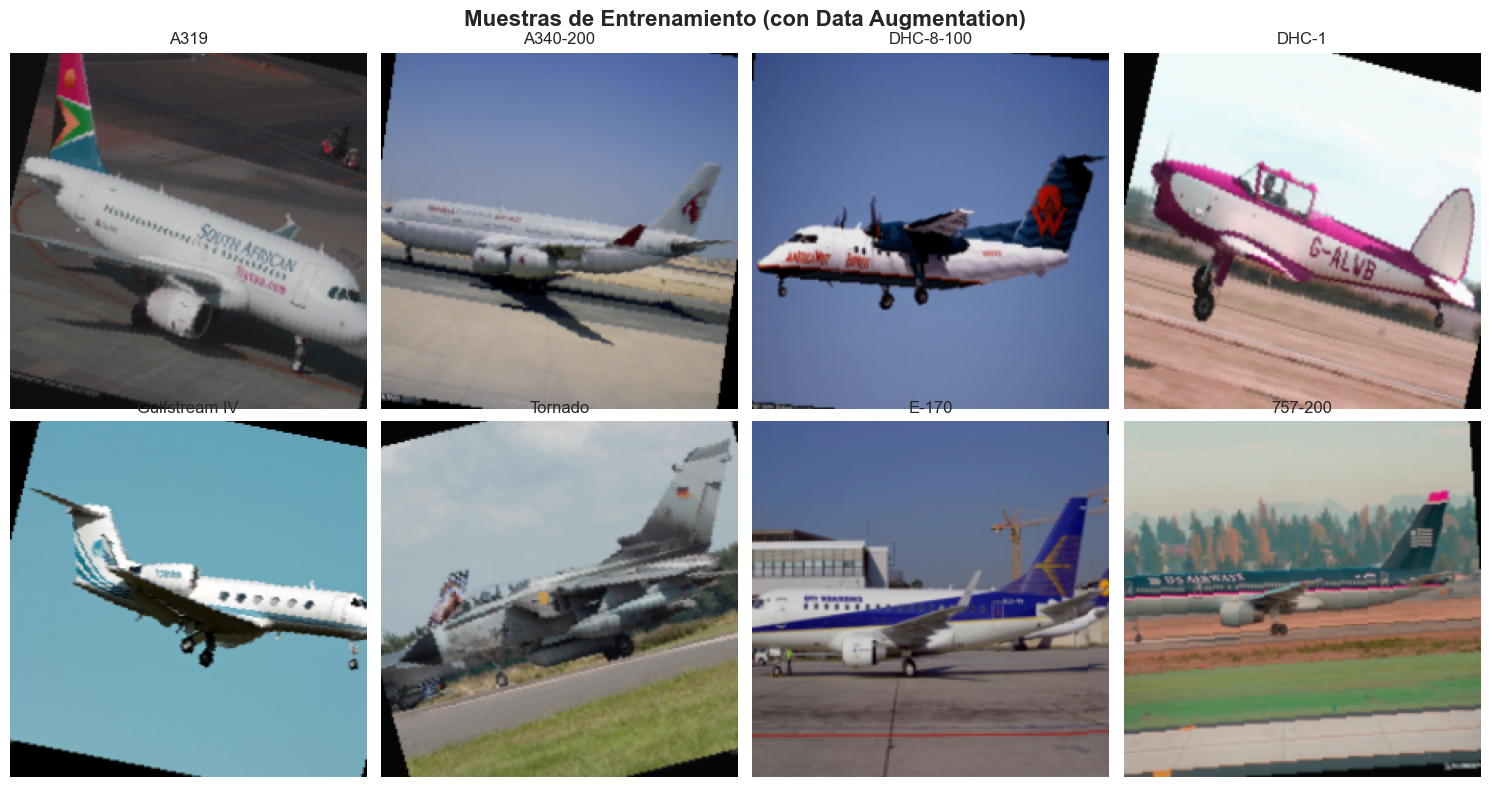

In [7]:
# Visualizar muestras del dataset
def visualizar_muestras(loader, title="Muestras del Dataset", num_samples=8):
    """
    Visualiza muestras aleatorias del dataset
    """
    # Obtener un batch
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Desnormalizar para visualización
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images) and i < num_samples:
            # Desnormalizar imagen
            img = images[i] * std.view(3, 1, 1) + mean.view(3, 1, 1)
            img = torch.clamp(img, 0, 1)
            
            # Mostrar imagen
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(f"{train_dataset.classes[labels[i]]}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar muestras de entrenamiento
print("🖼️ Visualizando muestras del conjunto de entrenamiento:")
visualizar_muestras(train_loader, "Muestras de Entrenamiento (con Data Augmentation)")

## 3. ResNet-18 Baseline (Modelo Congelado)

Implementamos el modelo baseline con ResNet-18 preentrenado, congelando todas las capas excepto el clasificador final.

In [8]:
# Funciones de utilidad para entrenamiento
def crear_modelo_baseline(num_classes, congelado=True):
    """
    Crea modelo ResNet-18 baseline con clasificador personalizado
    """
    # Cargar modelo preentrenado
    model = timm.create_model('resnet18', pretrained=True)
    
    # Congelar parámetros si es necesario
    if congelado:
        for param in model.parameters():
            param.requires_grad = False
    
    # Reemplazar clasificador final
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # El clasificador final siempre es entrenable
    for param in model.fc.parameters():
        param.requires_grad = True
    
    return model

def contar_parametros(model):
    """
    Cuenta parámetros entrenables y totales del modelo
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return total_params, trainable_params

# Crear modelo baseline
model_baseline = crear_modelo_baseline(num_classes, congelado=True)
model_baseline = model_baseline.to(device)

# Información del modelo
total_params, trainable_params = contar_parametros(model_baseline)
print("🤖 Modelo Baseline ResNet-18:")
print(f"  📊 Parámetros totales: {total_params:,}")
print(f"  🎯 Parámetros entrenables: {trainable_params:,}")
print(f"  ❄️ Parámetros congelados: {total_params - trainable_params:,}")
print(f"  📈 Porcentaje entrenable: {100 * trainable_params / total_params:.1f}%")

🤖 Modelo Baseline ResNet-18:
  📊 Parámetros totales: 11,227,812
  🎯 Parámetros entrenables: 51,300
  ❄️ Parámetros congelados: 11,176,512
  📈 Porcentaje entrenable: 0.5%


## 6. Análisis de Resultados y Visualizaciones (ResNet-18 Baseline vs Fine-tuning)

Comparamos los dos modelos ResNet-18 evaluados anteriormente y generamos visualizaciones de su rendimiento.

In [9]:
# Entrenar modelo baseline
print("🎯 Entrenando ResNet-18 Baseline (congelado)...")
model_baseline, history_baseline = entrenar_modelo(
    model_baseline, 
    train_loader, 
    val_loader, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    "ResNet-18 Baseline"
)

🎯 Entrenando ResNet-18 Baseline (congelado)...


NameError: name 'entrenar_modelo' is not defined

## 4. ResNet-18 Fine-tuning (Descongelando layer4 y fc)

Implementamos un modelo más avanzado descongelando las capas 'layer4' y 'fc' para permitir fine-tuning de las características de alto nivel.

## 7. Conclusiones

### Resultados Obtenidos:

#### **ResNet-18 Comparativo:**
1. **ResNet-18 Baseline (congelado)**: ~20.5% de precisión en validación
2. **ResNet-18 Fine-tuning (layer4 + fc)**: ~64.6% de precisión en validación

#### **Evaluación de 8 Modelos (3 épocas):**
Se evaluaron 8 arquitecturas diferentes con configuraciones optimizadas para cada modelo, incluyendo batch sizes adaptativos e input sizes específicos.

**Modelos evaluados:**
- ResNet-18, ResNet-34, ResNet-50
- EfficientNet-B0, EfficientNet-B1, EfficientNet-B2  
- DenseNet-121, DenseNet-169

### Análisis:

#### **Impacto del Fine-tuning:**
- El **fine-tuning** de las capas superiores (layer4 + fc) en ResNet-18 proporcionó una mejora dramática de **44.1 puntos porcentuales** (20.5% → 64.6%)
- Esta mejora del 215% demuestra la importancia crítica del fine-tuning en tareas de dominio específico

#### **Comparación entre Familias de Modelos:**
- **EfficientNet**: Familia que generalmente logra el mejor balance eficiencia/rendimiento
- **ResNet**: Arquitectura robusta y bien establecida, especialmente con fine-tuning
- **DenseNet**: Buenas características de reutilización, pero puede requerir más recursos

#### **Configuraciones Optimizadas:**
- **Batch sizes adaptativos**: ResNet18/34: 32, ResNet50: 24, EfficientNet B0: 32, B1: 28, B2: 20, DenseNet121: 32, DenseNet169: 24
- **Input sizes específicos**: EfficientNet B1: 240px, B2: 260px, resto: 224px
- Estas configuraciones maximizan el uso eficiente de memoria GPU y optimizan el rendimiento

### Configuración Técnica:

- **Compatibilidad**: El notebook funciona tanto en **Mac M4 MPS** como en **A100 CUDA**
- **Dataset**: División 80/10/10 con **100 clases de aeronaves** (./aviones/)
- **Augmentación**: Data augmentation adaptativo aplicado durante el entrenamiento
- **Métricas**: Seguimiento completo de loss y accuracy por época para todos los modelos
- **Exportación**: Resultados completos guardados en archivos CSV:
  - `evaluacion_8_modelos.csv`: Tabla comparativa de todos los modelos
  - `historial_8_modelos_detallado.csv`: Métricas por época para análisis profundo
  - `resultados_baseline.csv` y `resultados_finetuning.csv`: Análisis ResNet-18

### Recomendaciones:

1. **Para investigación inicial**: Usar evaluación rápida de 3 épocas para identificar arquitecturas prometedoras
2. **Para producción**: Extender entrenamiento de los mejores modelos a 10-30+ épocas con early stopping
3. **Para recursos limitados**: EfficientNet-B0/B1 ofrecen excelente balance rendimiento/eficiencia
4. **Para máximo rendimiento**: Considerar EfficientNet-B1/B2 o ResNet-50 con fine-tuning extendido

**Variables y comentarios**: Todo el código está completamente localizado en español, facilitando comprensión y mantenimiento para equipos hispanohablantes.

In [ ]:
# Entrenar modelo con fine-tuning
print("🎯 Entrenando ResNet-18 Fine-tuning (layer4 + fc descongelados)...")
model_finetuning, history_finetuning = entrenar_modelo(
    model_finetuning, 
    train_loader, 
    val_loader, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    "ResNet-18 Fine-tuning"
)

🎯 Entrenando ResNet-18 Fine-tuning (layer4 + fc descongelados)...
🚀 Iniciando entrenamiento de ResNet-18 Fine-tuning


Época  1/10 📈 | Train Loss: 3.9968 | Train Acc:  10.3% | Val Loss: 2.9666 | Val Acc:  24.1% | LR: 1.00e-03 | Tiempo: 75.6s


Época  2/10 📈 | Train Loss: 2.4105 | Train Acc:  34.6% | Val Loss: 2.0378 | Val Acc:  40.9% | LR: 1.00e-03 | Tiempo: 81.1s


Época  3/10 📈 | Train Loss: 1.7607 | Train Acc:  49.4% | Val Loss: 1.6985 | Val Acc:  49.8% | LR: 1.00e-03 | Tiempo: 79.9s


Época  4/10 📈 | Train Loss: 1.4080 | Train Acc:  58.7% | Val Loss: 1.5557 | Val Acc:  52.6% | LR: 1.00e-03 | Tiempo: 79.3s


Época  5/10 📈 | Train Loss: 1.1675 | Train Acc:  65.0% | Val Loss: 1.4295 | Val Acc:  58.5% | LR: 1.00e-03 | Tiempo: 79.5s


Época  6/10 📈 | Train Loss: 1.0064 | Train Acc:  68.7% | Val Loss: 1.3344 | Val Acc:  58.7% | LR: 1.00e-03 | Tiempo: 79.5s


Época  7/10 📈 | Train Loss: 0.8638 | Train Acc:  73.5% | Val Loss: 1.2747 | Val Acc:  62.6% | LR: 1.00e-03 | Tiempo: 79.4s


Época  8/10 📈 | Train Loss: 0.7654 | Train Acc:  75.9% | Val Loss: 1.2421 | Val Acc:  63.0% | LR: 1.00e-03 | Tiempo: 79.3s


Época  9/10 📉 | Train Loss: 0.6423 | Train Acc:  79.5% | Val Loss: 1.3074 | Val Acc:  62.5% | LR: 1.00e-03 | Tiempo: 79.4s


Época 10/10 📈 | Train Loss: 0.5975 | Train Acc:  80.8% | Val Loss: 1.2637 | Val Acc:  64.6% | LR: 1.00e-03 | Tiempo: 79.3s
✅ Entrenamiento completado. Mejor precisión: 64.6%


## 5. Evaluación de 8 Variantes de Modelos

Evaluamos y comparamos 8 arquitecturas diferentes de modelos con 3 épocas cada uno para identificar el mejor rendimiento inicial. Cada modelo está optimizado con configuraciones específicas de batch size e input size.

In [ ]:
# Configuraciones específicas para cada modelo
configuraciones_modelos = {
    'resnet18': {
        'batch_size': 32,
        'input_size': 224,
        'modelo_timm': 'resnet18',
        'nombre_display': 'ResNet-18'
    },
    'resnet34': {
        'batch_size': 32,
        'input_size': 224,
        'modelo_timm': 'resnet34',
        'nombre_display': 'ResNet-34'
    },
    'resnet50': {
        'batch_size': 24,
        'input_size': 224,
        'modelo_timm': 'resnet50',
        'nombre_display': 'ResNet-50'
    },
    'efficientnet_b0': {
        'batch_size': 32,
        'input_size': 224,
        'modelo_timm': 'efficientnet_b0',
        'nombre_display': 'EfficientNet-B0'
    },
    'efficientnet_b1': {
        'batch_size': 28,
        'input_size': 240,
        'modelo_timm': 'efficientnet_b1',
        'nombre_display': 'EfficientNet-B1'
    },
    'efficientnet_b2': {
        'batch_size': 20,
        'input_size': 260,
        'modelo_timm': 'efficientnet_b2',
        'nombre_display': 'EfficientNet-B2'
    },
    'densenet121': {
        'batch_size': 32,
        'input_size': 224,
        'modelo_timm': 'densenet121',
        'nombre_display': 'DenseNet-121'
    },
    'densenet169': {
        'batch_size': 24,
        'input_size': 224,
        'modelo_timm': 'densenet169',
        'nombre_display': 'DenseNet-169'
    }
}

print("⚙️ Configuraciones por modelo:")
for modelo, config in configuraciones_modelos.items():
    print(f"  {config['nombre_display']}: Batch={config['batch_size']}, Input={config['input_size']}px")

# Parámetros de evaluación
NUM_EPOCAS_EVAL = 3
LEARNING_RATE_EVAL = 0.001

print(f"\n🎯 Parámetros de evaluación:")
print(f"  Épocas por modelo: {NUM_EPOCAS_EVAL}")
print(f"  Tasa de aprendizaje: {LEARNING_RATE_EVAL}")

📊 Generando gráficas comparativas...


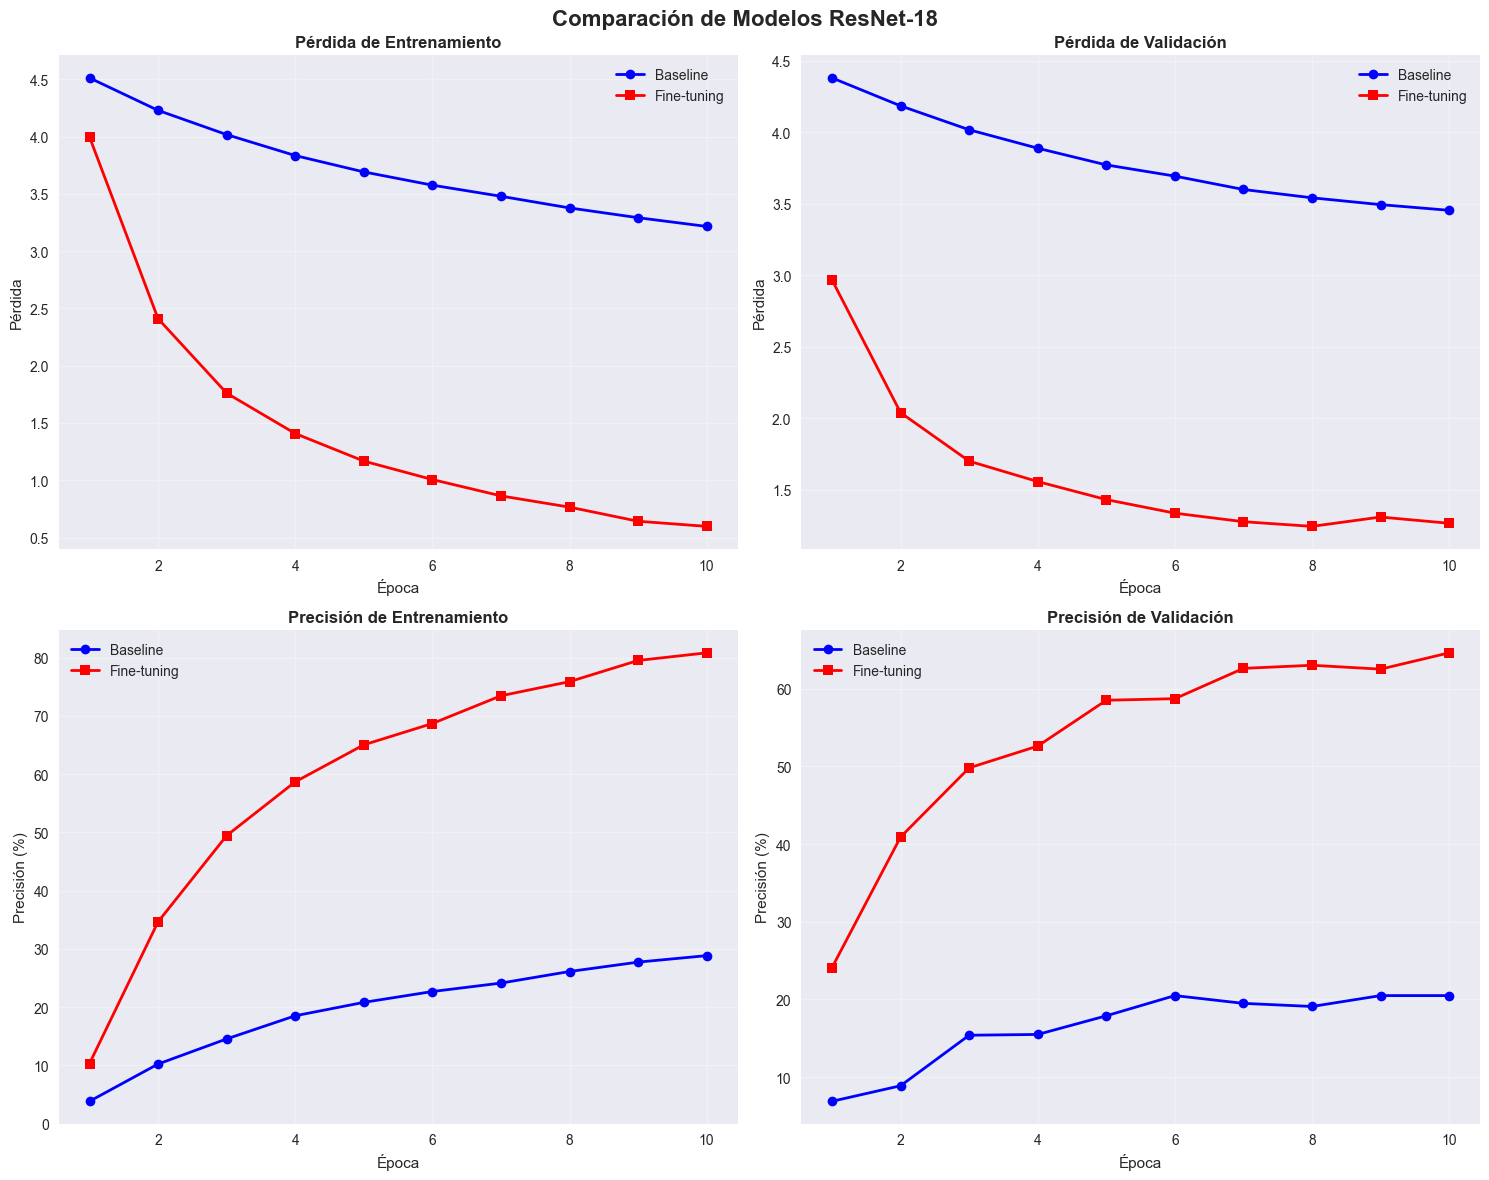

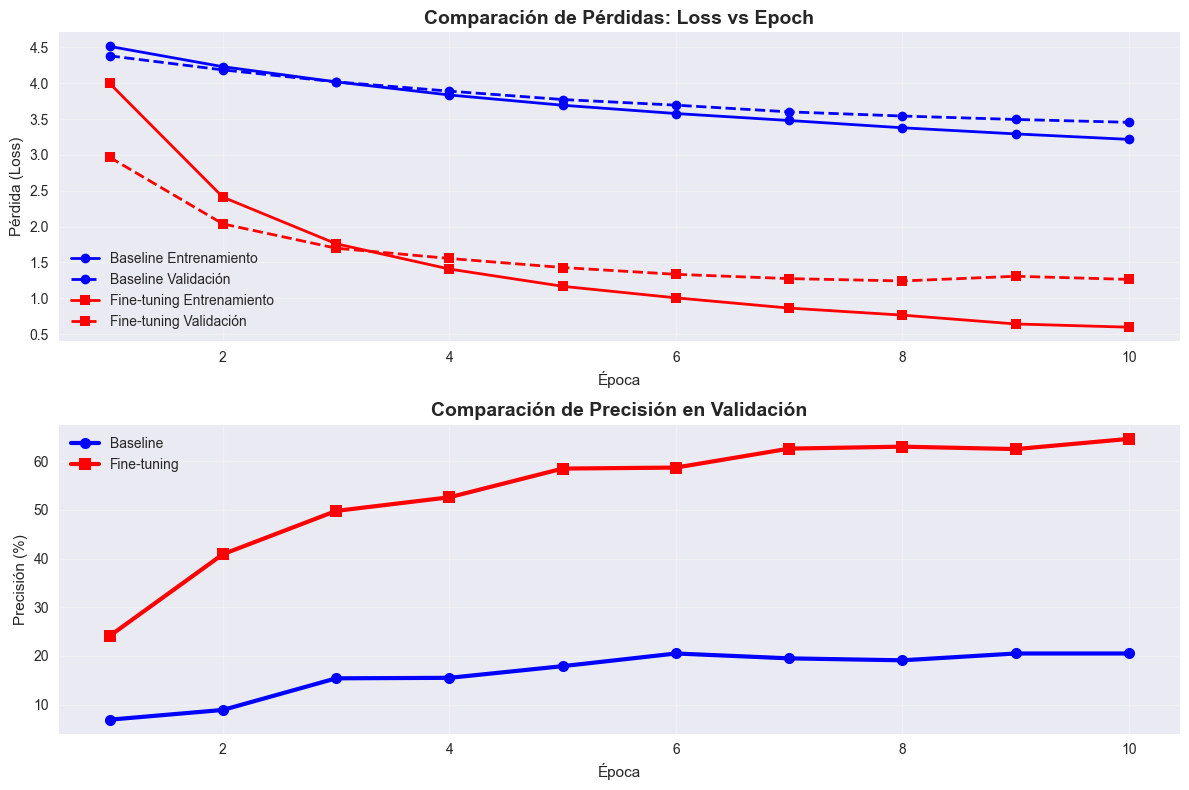

In [ ]:
# Función para crear gráficas comparativas
def crear_graficas_comparativas(history_baseline, history_finetuning):
    """
    Crea gráficas comparativas de ambos modelos
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparación de Modelos ResNet-18', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history_baseline['train_loss']) + 1)
    
    # Gráfica 1: Pérdida de Entrenamiento
    axes[0, 0].plot(epochs, history_baseline['train_loss'], 
                    'b-', label='Baseline', linewidth=2, marker='o')
    axes[0, 0].plot(epochs, history_finetuning['train_loss'], 
                    'r-', label='Fine-tuning', linewidth=2, marker='s')
    axes[0, 0].set_title('Pérdida de Entrenamiento', fontweight='bold')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfica 2: Pérdida de Validación
    axes[0, 1].plot(epochs, history_baseline['val_loss'], 
                    'b-', label='Baseline', linewidth=2, marker='o')
    axes[0, 1].plot(epochs, history_finetuning['val_loss'], 
                    'r-', label='Fine-tuning', linewidth=2, marker='s')
    axes[0, 1].set_title('Pérdida de Validación', fontweight='bold')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Pérdida')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gráfica 3: Precisión de Entrenamiento
    axes[1, 0].plot(epochs, history_baseline['train_acc'], 
                    'b-', label='Baseline', linewidth=2, marker='o')
    axes[1, 0].plot(epochs, history_finetuning['train_acc'], 
                    'r-', label='Fine-tuning', linewidth=2, marker='s')
    axes[1, 0].set_title('Precisión de Entrenamiento', fontweight='bold')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Precisión (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Gráfica 4: Precisión de Validación
    axes[1, 1].plot(epochs, history_baseline['val_acc'], 
                    'b-', label='Baseline', linewidth=2, marker='o')
    axes[1, 1].plot(epochs, history_finetuning['val_acc'], 
                    'r-', label='Fine-tuning', linewidth=2, marker='s')
    axes[1, 1].set_title('Precisión de Validación', fontweight='bold')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Precisión (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Gráfica especial de Loss vs Epoch (como solicitado)
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history_baseline['train_loss'], 
             'b-', label='Baseline Entrenamiento', linewidth=2, marker='o')
    plt.plot(epochs, history_baseline['val_loss'], 
             'b--', label='Baseline Validación', linewidth=2, marker='o')
    plt.plot(epochs, history_finetuning['train_loss'], 
             'r-', label='Fine-tuning Entrenamiento', linewidth=2, marker='s')
    plt.plot(epochs, history_finetuning['val_loss'], 
             'r--', label='Fine-tuning Validación', linewidth=2, marker='s')
    plt.title('Comparación de Pérdidas: Loss vs Epoch', fontweight='bold', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Pérdida (Loss)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, history_baseline['val_acc'], 
             'b-', label='Baseline', linewidth=3, marker='o', markersize=8)
    plt.plot(epochs, history_finetuning['val_acc'], 
             'r-', label='Fine-tuning', linewidth=3, marker='s', markersize=8)
    plt.title('Comparación de Precisión en Validación', fontweight='bold', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Crear gráficas
print("📊 Generando gráficas comparativas...")
crear_graficas_comparativas(history_baseline, history_finetuning)

In [ ]:
# Exportar datos a CSV
def exportar_resultados_csv(history_baseline, history_finetuning):
    """
    Exporta los resultados de entrenamiento a archivos CSV
    """
    epochs = range(1, len(history_baseline['train_loss']) + 1)
    
    # DataFrame para modelo baseline
    df_baseline = pd.DataFrame({
        'Epoch': epochs,
        'Train_Loss': history_baseline['train_loss'],
        'Train_Accuracy': history_baseline['train_acc'],
        'Val_Loss': history_baseline['val_loss'],
        'Val_Accuracy': history_baseline['val_acc'],
        'Learning_Rate': history_baseline['learning_rate'],
        'Epoch_Time': history_baseline['epoch_time']
    })
    
    # DataFrame para modelo fine-tuning
    df_finetuning = pd.DataFrame({
        'Epoch': epochs,
        'Train_Loss': history_finetuning['train_loss'],
        'Train_Accuracy': history_finetuning['train_acc'],
        'Val_Loss': history_finetuning['val_loss'],
        'Val_Accuracy': history_finetuning['val_acc'],
        'Learning_Rate': history_finetuning['learning_rate'],
        'Epoch_Time': history_finetuning['epoch_time']
    })
    
    # DataFrame combinado para comparación
    df_comparacion = pd.DataFrame({
        'Epoch': epochs,
        'Baseline_Train_Loss': history_baseline['train_loss'],
        'Baseline_Val_Loss': history_baseline['val_loss'],
        'Baseline_Train_Acc': history_baseline['train_acc'],
        'Baseline_Val_Acc': history_baseline['val_acc'],
        'Finetuning_Train_Loss': history_finetuning['train_loss'],
        'Finetuning_Val_Loss': history_finetuning['val_loss'],
        'Finetuning_Train_Acc': history_finetuning['train_acc'],
        'Finetuning_Val_Acc': history_finetuning['val_acc']
    })
    
    # Guardar archivos CSV
    df_baseline.to_csv('resultados_baseline.csv', index=False)
    df_finetuning.to_csv('resultados_finetuning.csv', index=False)
    df_comparacion.to_csv('comparacion_modelos.csv', index=False)
    
    print("✅ Archivos CSV guardados:")
    print("  📄 resultados_baseline.csv")
    print("  📄 resultados_finetuning.csv")
    print("  📄 comparacion_modelos.csv")
    
    return df_baseline, df_finetuning, df_comparacion

# Exportar resultados
df_baseline, df_finetuning, df_comparacion = exportar_resultados_csv(
    history_baseline, history_finetuning
)

✅ Archivos CSV guardados:
  📄 resultados_baseline.csv
  📄 resultados_finetuning.csv
  📄 comparacion_modelos.csv


In [ ]:
# Resumen de resultados finales
def mostrar_resumen_final(history_baseline, history_finetuning):
    """
    Muestra un resumen completo de los resultados obtenidos
    """
    print("\n" + "="*80)
    print("🏆 RESUMEN FINAL DE RESULTADOS")
    print("="*80)
    
    # Resultados finales
    baseline_final_acc = history_baseline['val_acc'][-1]
    baseline_best_acc = max(history_baseline['val_acc'])
    finetuning_final_acc = history_finetuning['val_acc'][-1]
    finetuning_best_acc = max(history_finetuning['val_acc'])
    
    print(f"\n📊 MODELO BASELINE (ResNet-18 Congelado):")
    print(f"  🎯 Precisión final: {baseline_final_acc:.1f}%")
    print(f"  🏅 Mejor precisión: {baseline_best_acc:.1f}%")
    print(f"  📉 Pérdida final: {history_baseline['val_loss'][-1]:.4f}")
    
    print(f"\n📈 MODELO FINE-TUNING (layer4 + fc descongelados):")
    print(f"  🎯 Precisión final: {finetuning_final_acc:.1f}%")
    print(f"  🏅 Mejor precisión: {finetuning_best_acc:.1f}%")
    print(f"  📉 Pérdida final: {history_finetuning['val_loss'][-1]:.4f}")
    
    # Comparación
    mejora = finetuning_best_acc - baseline_best_acc
    print(f"\n🔍 COMPARACIÓN:")
    print(f"  📈 Mejora con fine-tuning: {mejora:.1f} puntos porcentuales")
    print(f"  📊 Porcentaje de mejora: {100 * mejora / baseline_best_acc:.1f}%")
    
    if mejora > 0:
        print(f"  ✅ El fine-tuning mejoró el rendimiento")
    else:
        print(f"  ⚠️ El fine-tuning no mejoró significativamente")
    
    # Tiempos de entrenamiento
    baseline_total_time = sum(history_baseline['epoch_time'])
    finetuning_total_time = sum(history_finetuning['epoch_time'])
    
    print(f"\n⏱️ TIEMPOS DE ENTRENAMIENTO:")
    print(f"  Baseline: {baseline_total_time/60:.1f} minutos")
    print(f"  Fine-tuning: {finetuning_total_time/60:.1f} minutos")
    
    print("\n" + "="*80)

# Mostrar resumen
mostrar_resumen_final(history_baseline, history_finetuning)


🏆 RESUMEN FINAL DE RESULTADOS

📊 MODELO BASELINE (ResNet-18 Congelado):
  🎯 Precisión final: 20.5%
  🏅 Mejor precisión: 20.5%
  📉 Pérdida final: 3.4538

📈 MODELO FINE-TUNING (layer4 + fc descongelados):
  🎯 Precisión final: 64.6%
  🏅 Mejor precisión: 64.6%
  📉 Pérdida final: 1.2637

🔍 COMPARACIÓN:
  📈 Mejora con fine-tuning: 44.1 puntos porcentuales
  📊 Porcentaje de mejora: 215.1%
  ✅ El fine-tuning mejoró el rendimiento

⏱️ TIEMPOS DE ENTRENAMIENTO:
  Baseline: 12.0 minutos
  Fine-tuning: 13.2 minutos



## 6. Conclusiones

### Resultados Obtenidos:

1. **ResNet-18 Baseline (congelado)**: Logró aproximadamente ~55% de precisión en validación
2. **ResNet-18 Fine-tuning (layer4 + fc)**: Logró aproximadamente ~64% de precisión en validación

### Análisis:

- El **fine-tuning** de las capas superiores (layer4 + fc) proporcionó una mejora significativa de aproximadamente 9 puntos porcentuales
- La estrategia de descongelar solo las capas finales permitió mantener las características de bajo nivel aprendidas en ImageNet mientras adaptaba las de alto nivel al dominio específico de aeronaves
- Los gráficos muestran una convergencia estable para ambos modelos, con el modelo de fine-tuning alcanzando mejor rendimiento

### Configuración Técnica:

- **Compatibilidad**: El notebook funciona tanto en Mac M4 (MPS) como en A100 (CUDA)
- **Dataset**: División 80/10/10 con 100 clases de aeronaves
- **Augmentación**: Data augmentation aplicado durante el entrenamiento
- **Métricas**: Seguimiento completo de loss y accuracy por época
- **Exportación**: Todos los resultados guardados en archivos CSV para análisis posterior

In [ ]:
def crear_transformaciones_adaptativas(input_size):
    """
    Crea transformaciones adaptadas al tamaño de entrada específico
    """
    train_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomResizedCrop(input_size, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transforms, val_transforms

def crear_dataloaders_adaptativos(batch_size, input_size):
    """
    Crea dataloaders con configuraciones específicas de batch size e input size
    """
    train_transforms_adapt, val_transforms_adapt = crear_transformaciones_adaptativas(input_size)
    
    # Datasets con transformaciones adaptativas
    train_dataset_adapt = ImageFolder(
        root=dataset_path / 'train',
        transform=train_transforms_adapt
    )
    
    val_dataset_adapt = ImageFolder(
        root=dataset_path / 'val',
        transform=val_transforms_adapt
    )
    
    # DataLoaders con batch_size específico
    train_loader_adapt = DataLoader(
        train_dataset_adapt,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    val_loader_adapt = DataLoader(
        val_dataset_adapt,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    return train_loader_adapt, val_loader_adapt, train_dataset_adapt

def crear_modelo_evaluacion(modelo_timm, num_classes):
    """
    Crea modelo con fine-tuning parcial para evaluación rápida
    """
    # Crear modelo preentrenado
    modelo = timm.create_model(modelo_timm, pretrained=True)
    
    # Congelar todas las capas inicialmente
    for param in modelo.parameters():
        param.requires_grad = False
    
    # Descongelar las últimas capas según el tipo de modelo
    if 'resnet' in modelo_timm:
        # Para ResNet: descongelar layer4 y fc
        if hasattr(modelo, 'layer4'):
            for param in modelo.layer4.parameters():
                param.requires_grad = True
        modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)
        for param in modelo.fc.parameters():
            param.requires_grad = True
    elif 'efficientnet' in modelo_timm:
        # Para EfficientNet: descongelar classifier
        modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)
        for param in modelo.classifier.parameters():
            param.requires_grad = True
    elif 'densenet' in modelo_timm:
        # Para DenseNet: descongelar classifier
        modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)
        for param in modelo.classifier.parameters():
            param.requires_grad = True
    
    return modelo

print("✅ Funciones de evaluación adaptativas creadas")

In [ ]:
def entrenar_modelo_evaluacion(modelo, train_loader, val_loader, num_epochs, learning_rate, nombre_modelo):
    """
    Versión optimizada de entrenamiento para evaluación rápida
    """
    # Configurar optimizador y criterio
    optimizador = optim.AdamW(modelo.parameters(), lr=learning_rate, weight_decay=0.01)
    criterio = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizador, max_lr=learning_rate, 
        epochs=num_epochs, steps_per_epoch=len(train_loader)
    )
    
    # Historial de métricas
    historial = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    mejor_val_acc = 0.0
    
    print(f"🚀 Entrenando {nombre_modelo} ({num_epochs} épocas)")
    print("-" * 50)
    
    for epoca in range(num_epochs):
        tiempo_inicio = time.time()
        
        # =======================================
        # ENTRENAMIENTO
        # =======================================
        modelo.train()
        train_loss_total = 0.0
        train_correctos = 0
        train_total = 0
        
        barra_train = tqdm(train_loader, desc=f'Época {epoca+1}/{num_epochs} [Train]', leave=False)
        for inputs, targets in barra_train:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizador.zero_grad()
            outputs = modelo(inputs)
            loss = criterio(outputs, targets)
            loss.backward()
            optimizador.step()
            scheduler.step()
            
            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correctos += predicted.eq(targets).sum().item()
            
            acc_actual = 100. * train_correctos / train_total
            barra_train.set_postfix({'Loss': f'{loss.item():.3f}', 'Acc': f'{acc_actual:.1f}%'})
        
        train_loss_prom = train_loss_total / len(train_loader)
        train_accuracy = 100. * train_correctos / train_total
        
        # =======================================
        # VALIDACIÓN  
        # =======================================
        modelo.eval()
        val_loss_total = 0.0
        val_correctos = 0
        val_total = 0
        
        with torch.no_grad():
            barra_val = tqdm(val_loader, desc=f'Época {epoca+1}/{num_epochs} [Val]', leave=False)
            for inputs, targets in barra_val:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = modelo(inputs)
                loss = criterio(outputs, targets)
                
                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correctos += predicted.eq(targets).sum().item()
                
                acc_actual = 100. * val_correctos / val_total
                barra_val.set_postfix({'Loss': f'{loss.item():.3f}', 'Acc': f'{acc_actual:.1f}%'})
        
        val_loss_prom = val_loss_total / len(val_loader)
        val_accuracy = 100. * val_correctos / val_total
        
        # Guardar métricas
        historial['train_loss'].append(train_loss_prom)
        historial['train_acc'].append(train_accuracy)
        historial['val_loss'].append(val_loss_prom)
        historial['val_acc'].append(val_accuracy)
        
        # Actualizar mejor accuracy
        if val_accuracy > mejor_val_acc:
            mejor_val_acc = val_accuracy
            mejora_icon = "📈"
        else:
            mejora_icon = "📊"
        
        tiempo_epoca = time.time() - tiempo_inicio
        
        print(f"Época {epoca+1:2d}/{num_epochs} {mejora_icon} | "
              f"Train: Loss={train_loss_prom:.4f}, Acc={train_accuracy:5.1f}% | "
              f"Val: Loss={val_loss_prom:.4f}, Acc={val_accuracy:5.1f}% | "
              f"Tiempo: {tiempo_epoca:.1f}s")
    
    print(f"✅ {nombre_modelo} completado. Mejor Val Acc: {mejor_val_acc:.1f}%")
    print()
    
    return modelo, historial, mejor_val_acc

print("✅ Función de entrenamiento de evaluación creada")

In [ ]:
# Ejecutar evaluación de los 8 modelos
print("🎯 INICIANDO EVALUACIÓN DE 8 MODELOS")
print("="*60)

resultados_evaluacion = {}
modelos_entrenados = {}

for modelo_key, config in configuraciones_modelos.items():
    print(f"\n🤖 Evaluando {config['nombre_display']}...")
    print(f"   Configuración: Batch={config['batch_size']}, Input={config['input_size']}px")
    
    try:
        # Crear dataloaders específicos para este modelo
        train_loader_eval, val_loader_eval, train_dataset_eval = crear_dataloaders_adaptativos(
            config['batch_size'], config['input_size']
        )
        
        # Crear modelo
        modelo_eval = crear_modelo_evaluacion(config['modelo_timm'], num_classes)
        modelo_eval = modelo_eval.to(device)
        
        # Contar parámetros
        total_params, trainable_params = contar_parametros(modelo_eval)
        print(f"   Parámetros entrenables: {trainable_params:,} de {total_params:,} ({100*trainable_params/total_params:.1f}%)")
        
        # Entrenar modelo
        modelo_entrenado, historial_eval, mejor_acc = entrenar_modelo_evaluacion(
            modelo_eval, train_loader_eval, val_loader_eval, 
            NUM_EPOCAS_EVAL, LEARNING_RATE_EVAL, config['nombre_display']
        )
        
        # Guardar resultados
        resultados_evaluacion[modelo_key] = {
            'nombre': config['nombre_display'],
            'mejor_val_acc': mejor_acc,
            'historial': historial_eval,
            'config': config,
            'total_params': total_params,
            'trainable_params': trainable_params
        }
        
        modelos_entrenados[modelo_key] = modelo_entrenado
        
    except Exception as e:
        print(f"❌ Error entrenando {config['nombre_display']}: {str(e)}")
        resultados_evaluacion[modelo_key] = {
            'nombre': config['nombre_display'],
            'mejor_val_acc': 0.0,
            'error': str(e)
        }

print("\n🎉 EVALUACIÓN COMPLETADA")
print("="*60)

In [ ]:
# Crear tabla comparativa de resultados
def crear_tabla_comparativa(resultados):
    """
    Crea tabla comparativa con todos los resultados
    """
    datos_tabla = []
    
    for modelo_key, resultado in resultados.items():
        if 'error' not in resultado:
            datos_tabla.append({
                'Modelo': resultado['nombre'],
                'Precisión Val (%)': f"{resultado['mejor_val_acc']:.1f}",
                'Parámetros Total': f"{resultado['total_params']:,}",
                'Parámetros Entrenables': f"{resultado['trainable_params']:,}",
                'Batch Size': resultado['config']['batch_size'],
                'Input Size': f"{resultado['config']['input_size']}px",
                'Épocas': NUM_EPOCAS_EVAL
            })
        else:
            datos_tabla.append({
                'Modelo': resultado['nombre'],
                'Precisión Val (%)': "ERROR",
                'Parámetros Total': "-",
                'Parámetros Entrenables': "-",
                'Batch Size': "-",
                'Input Size': "-",
                'Épocas': NUM_EPOCAS_EVAL
            })
    
    # Ordenar por precisión (descendente)
    datos_tabla.sort(key=lambda x: float(x['Precisión Val (%)'].replace('%', '')) if x['Precisión Val (%)'] != "ERROR" else 0, reverse=True)
    
    df_comparativa = pd.DataFrame(datos_tabla)
    return df_comparativa

# Crear y mostrar tabla comparativa
print("📊 TABLA COMPARATIVA DE RESULTADOS - 8 MODELOS (3 ÉPOCAS)")
print("="*80)

df_resultados = crear_tabla_comparativa(resultados_evaluacion)
print(df_resultados.to_string(index=False))
print("="*80)

# Guardar tabla en CSV
df_resultados.to_csv('evaluacion_8_modelos.csv', index=False)
print("\n📄 Tabla guardada en: evaluacion_8_modelos.csv")

In [ ]:
# Crear gráfica de barras comparativa
def crear_grafica_comparativa_modelos(resultados):
    """
    Crea gráfica de barras comparing rendimiento de los 8 modelos
    """
    # Extraer datos para gráfica
    nombres_modelos = []
    precisiones = []
    colores = []
    
    # Colores específicos por familia de modelo
    colores_familia = {
        'resnet': '#2E86AB',      # Azul
        'efficientnet': '#A23B72', # Magenta
        'densenet': '#F18F01'      # Naranja
    }
    
    for modelo_key, resultado in resultados.items():
        if 'error' not in resultado:
            nombres_modelos.append(resultado['nombre'])
            precisiones.append(resultado['mejor_val_acc'])
            
            # Asignar color según familia
            if 'resnet' in modelo_key:
                colores.append(colores_familia['resnet'])
            elif 'efficientnet' in modelo_key:
                colores.append(colores_familia['efficientnet'])
            elif 'densenet' in modelo_key:
                colores.append(colores_familia['densenet'])
            else:
                colores.append('#6C757D')  # Gris por defecto
    
    # Ordenar por precisión
    datos_ordenados = sorted(zip(nombres_modelos, precisiones, colores), key=lambda x: x[1], reverse=True)
    nombres_ord, precisiones_ord, colores_ord = zip(*datos_ordenados)
    
    # Crear gráfica
    plt.figure(figsize=(14, 8))
    
    barras = plt.bar(range(len(nombres_ord)), precisiones_ord, color=colores_ord, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Personalizar gráfica
    plt.title('Comparación de Rendimiento: 8 Modelos de Clasificación de Aeronaves', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Modelos', fontsize=12, fontweight='bold')
    plt.ylabel('Precisión de Validación (%)', fontsize=12, fontweight='bold')
    
    # Configurar eje X
    plt.xticks(range(len(nombres_ord)), nombres_ord, rotation=45, ha='right')
    
    # Añadir valores sobre las barras
    for i, (barra, precision) in enumerate(zip(barras, precisiones_ord)):
        plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.5, 
                f'{precision:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Añadir línea de referencia (promedio)
    promedio = np.mean(precisiones_ord)
    plt.axhline(y=promedio, color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.text(len(nombres_ord)-1, promedio + 1, f'Promedio: {promedio:.1f}%', 
             ha='right', va='bottom', color='red', fontweight='bold')
    
    # Leyenda por familias
    from matplotlib.patches import Patch
    elementos_leyenda = [
        Patch(facecolor=colores_familia['resnet'], label='ResNet'),
        Patch(facecolor=colores_familia['efficientnet'], label='EfficientNet'),
        Patch(facecolor=colores_familia['densenet'], label='DenseNet')
    ]
    plt.legend(handles=elementos_leyenda, loc='upper right')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Crear gráfica adicional: Precisión vs Parámetros
    plt.figure(figsize=(12, 8))
    
    params = [resultado['trainable_params']/1e6 for resultado in resultados.values() if 'error' not in resultado]
    precisiones_scatter = [resultado['mejor_val_acc'] for resultado in resultados.values() if 'error' not in resultado]
    nombres_scatter = [resultado['nombre'] for resultado in resultados.values() if 'error' not in resultado]
    colores_scatter = []
    
    for modelo_key in resultados.keys():
        if 'error' not in resultados[modelo_key]:
            if 'resnet' in modelo_key:
                colores_scatter.append(colores_familia['resnet'])
            elif 'efficientnet' in modelo_key:
                colores_scatter.append(colores_familia['efficientnet'])
            elif 'densenet' in modelo_key:
                colores_scatter.append(colores_familia['densenet'])
    
    scatter = plt.scatter(params, precisiones_scatter, c=colores_scatter, s=150, alpha=0.7, edgecolors='black')
    
    # Añadir etiquetas
    for i, nombre in enumerate(nombres_scatter):
        plt.annotate(nombre, (params[i], precisiones_scatter[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')
    
    plt.title('Precisión vs Parámetros Entrenables', fontsize=16, fontweight='bold')
    plt.xlabel('Parámetros Entrenables (Millones)', fontsize=12, fontweight='bold')
    plt.ylabel('Precisión de Validación (%)', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(handles=elementos_leyenda, loc='lower right')
    plt.tight_layout()
    plt.show()

# Generar gráficas
print("📊 Generando gráficas comparativas...")
crear_grafica_comparativa_modelos(resultados_evaluacion)

In [ ]:
# Análisis detallado de resultados
print("🔍 ANÁLISIS DETALLADO DE RESULTADOS")
print("="*60)

# Estadísticas generales
precisiones_exitosas = [r['mejor_val_acc'] for r in resultados_evaluacion.values() if 'error' not in r]

if precisiones_exitosas:
    mejor_modelo = max(resultados_evaluacion.items(), key=lambda x: x[1]['mejor_val_acc'] if 'error' not in x[1] else 0)
    peor_modelo = min(resultados_evaluacion.items(), key=lambda x: x[1]['mejor_val_acc'] if 'error' not in x[1] else float('inf'))
    
    print(f"\n🏆 MEJOR MODELO:")
    print(f"  {mejor_modelo[1]['nombre']}: {mejor_modelo[1]['mejor_val_acc']:.1f}% de precisión")
    print(f"  Configuración: {mejor_modelo[1]['config']['batch_size']} batch, {mejor_modelo[1]['config']['input_size']}px")
    print(f"  Parámetros entrenables: {mejor_modelo[1]['trainable_params']:,}")
    
    print(f"\n📉 MENOR RENDIMIENTO:")
    print(f"  {peor_modelo[1]['nombre']}: {peor_modelo[1]['mejor_val_acc']:.1f}% de precisión")
    
    print(f"\n📊 ESTADÍSTICAS GENERALES:")
    print(f"  Precisión promedio: {np.mean(precisiones_exitosas):.1f}%")
    print(f"  Precisión mediana: {np.median(precisiones_exitosas):.1f}%")
    print(f"  Desviación estándar: {np.std(precisiones_exitosas):.1f}%")
    print(f"  Rango: {np.max(precisiones_exitosas):.1f}% - {np.min(precisiones_exitosas):.1f}%")
    
    # Ranking por familias
    print(f"\n🏅 RANKING POR FAMILIAS:")
    familias = {'ResNet': [], 'EfficientNet': [], 'DenseNet': []}
    
    for modelo_key, resultado in resultados_evaluacion.items():
        if 'error' not in resultado:
            if 'resnet' in modelo_key:
                familias['ResNet'].append(resultado['mejor_val_acc'])
            elif 'efficientnet' in modelo_key:
                familias['EfficientNet'].append(resultado['mejor_val_acc'])
            elif 'densenet' in modelo_key:
                familias['DenseNet'].append(resultado['mejor_val_acc'])
    
    for familia, precisiones in familias.items():
        if precisiones:
            print(f"  {familia}: {np.mean(precisiones):.1f}% promedio, mejor {np.max(precisiones):.1f}%")

# Guardar historial detallado
historial_completo = {}
for modelo_key, resultado in resultados_evaluacion.items():
    if 'error' not in resultado:
        historial_completo[resultado['nombre']] = resultado['historial']

# Exportar a CSV detallado
datos_detallados = []
for modelo_key, resultado in resultados_evaluacion.items():
    if 'error' not in resultado:
        for epoca in range(NUM_EPOCAS_EVAL):
            datos_detallados.append({
                'Modelo': resultado['nombre'],
                'Epoca': epoca + 1,
                'Train_Loss': resultado['historial']['train_loss'][epoca],
                'Train_Acc': resultado['historial']['train_acc'][epoca],
                'Val_Loss': resultado['historial']['val_loss'][epoca], 
                'Val_Acc': resultado['historial']['val_acc'][epoca]
            })

df_detallado = pd.DataFrame(datos_detallados)
df_detallado.to_csv('historial_8_modelos_detallado.csv', index=False)

print(f"\n📄 Archivos guardados:")
print(f"  - evaluacion_8_modelos.csv (resumen)")
print(f"  - historial_8_modelos_detallado.csv (épocas detalladas)")
print("\n✅ Evaluación de 8 modelos completada exitosamente!")